In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, solve_ivp, fixed_quad
from scipy.special import kn
import astropy.constants as ct
import pandas as pd
from scipy.optimize import newton
from scipy.interpolate import interp1d
from scipy.differentiate import derivative
from ipywidgets import interact,fixed,widgets,interactive
import concurrent.futures as ft
from functools import partial

In [2]:
# constants

vev = 246 # GeV - Higgs VEV
m_h = 125.2 # GeV - Higgs mass
Gamma_h = 4.07e-3 # GeV - total Higgs decay width
M_W = 80.3692 # GeV - W boson mass
M_Z = 91.188 # GeV - Z boson mass

m_e = 0.511e-3 # GeV - electron mass
m_muon = 105.66e-3 # GeV - muon mass
m_tau = 1.77693 # GeV - tau mass
m_u = 2.16e-3 # GeV - up mass
m_d = 4.7e-3 # GeV - down mass
m_c = 1.273 # GeV - charm mass
m_s = 93.5e-3 # GeV - strange mass
m_t = 172.57 # GeV - top mass
m_b = 4.183 # GeV - bottom mass

M_V = [M_W, M_Z]
M_f = [m_e,m_muon,m_tau,m_u,m_d,m_c,m_s,m_t,m_b]
n_cs = [1,1,1,3,3,3,3,3,3]

c_V = [1,1/2]

g_V = 3
g_f = 2

# C = 0.349 # no sé qué es esto
C = 1 - 5.792e-1 -6.240e-2 - 2.165e-4 - 2.876e-4

gstar = 106.75
MP = 2.4e18
T0 = 2.725*ct.k_B.value/ct.e.value*1e-9
gstars0 = 3.91
gstar0 = 3.38
s0 = 2*np.pi**2/45*gstars0*T0**3
rhoc0 = 4.78658e-5*1e6*ct.c.value**3*ct.hbar.value**3/ct.e.value**3*(1e-9)**4 # GeV⁴
gS = 1

s0mo = 2.8912e9*(ct.c.value/ct.hbar.value*ct.e.value*1e-9)**(-3)
rhoc0mo = 10.537*(ct.c.value/ct.hbar.value*ct.e.value*1e-9)**(-3)



In [3]:
rdof = pd.read_csv('https://raw.githubusercontent.com/SantiagoJulioD/Trabajo_de_grado/refs/heads/main/FIMP_fermion/rdof.csv')
rdof.loc[250,'Temp'] = T0
rdof['lnTemp'] = np.log(rdof['Temp'])
rdof['lnheff'] = np.log(rdof['g_s'])
rdof

,Temp,g_s,g_rho,lnTemp,lnheff
0,5.000000e+05,104.51300,104.51600,13.122363,4.649311
1,4.530790e+05,104.51000,104.51300,13.023822,4.649283
2,4.105620e+05,104.50700,104.51000,12.925282,4.649254
3,3.720340e+05,104.50400,104.50700,12.826741,4.649225
4,3.371220e+05,104.50100,104.50400,12.728200,4.649197
...,...,...,...,...,...
246,1.483140e-05,3.91752,3.37064,-11.118764,1.365459
247,1.343960e-05,3.91750,3.37062,-11.217305,1.365454
248,1.217840e-05,3.91751,3.37063,-11.315847,1.365456
249,1.103560e-05,3.91757,3.37070,-11.414384,1.365472


In [4]:
SM_particles = pd.DataFrame(index=['h','W','Z','e','mu','tau','u','d','c','s','t','b'])
SM_particles['mass'] = np.array([m_h,]+M_V+M_f)
SM_particles['spin'] = np.array([0,1,1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
SM_particles['n_c'] = np.array([1,1,1,1,1,1,3,3,3,3,3,3])
SM_particles['dof'] = 2*SM_particles['spin']+1
SM_particles['antiparticle'] = np.array([0.5,1,0.5,1,1,1,1,1,1,1,1,1])
SM_particles['name'] = np.array(['Higgs','W± boson','Z0 boson','electron','muon','tau','up quark','down quark','charm quark','strange quark','top quark','bottom quark'])

In [5]:
heff = interp1d(rdof['Temp'][::-1],rdof['g_s'][::-1],bounds_error=False,fill_value=(rdof['g_s'].values[-1],rdof['g_s'].values[0]))
geff = interp1d(rdof['Temp'][::-1],rdof['g_rho'][::-1],bounds_error=False,fill_value=(rdof['g_rho'].values[-1],rdof['g_rho'].values[0]))
lnheff = interp1d(rdof['lnTemp'][::-1],rdof['lnheff'][::-1],bounds_error=False,fill_value=(rdof['lnheff'].values[-1],rdof['lnheff'].values[0]))
der = derivative(lnheff,rdof['lnTemp']).df
dlnheffdlnT = interp1d(rdof['lnTemp'][::-1],der[::-1],bounds_error=False,fill_value=(der[-1],der[0]))

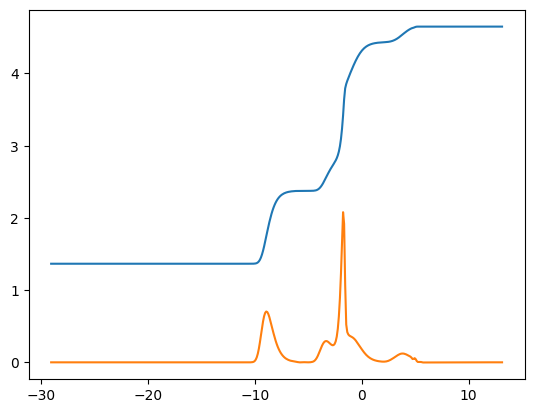

In [6]:
der = derivative(lnheff,rdof['lnTemp']).df

plt.plot(rdof['lnTemp'],rdof['lnheff'])
plt.plot(rdof['lnTemp'],dlnheffdlnT(rdof['lnTemp']))

In [7]:
def sigma(w,M_S,lambda_HS,initial_particle):
    if initial_particle == 'h':
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        if (np.tan(w)-M_S**2/M**2)/(np.tan(w)-1)>0:# M_S<=M*np.tan(w)**0.5:
            A_ = g**-2*(2*lambda_HS)**2/(128*M**2*np.pi*np.tan(w))
            B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1))**0.5
            C_ = ((2*lambda_HS)+3*M/(4*M*np.tan(w)-M+1j*Gamma_h)-2*vev**2*(2*lambda_HS)/(2*M**2*np.tan(w)-M**2))
            return (A_*B_*np.abs(C_)**2)
        else:
            return 0
    if SM_particles.loc[initial_particle]['spin'] == 1.:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        if (np.tan(w)-M_S**2/M**2)/(np.tan(w)-1)>0:#M_S<=M*np.tan(w)**0.5:
            A_ = g**-2*(2*lambda_HS)**2*M**2/(32*np.pi*np.tan(w))
            B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1))**0.5
            C_ = (4*np.tan(w)**2-4*np.tan(w)+3)/((4*M**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
            return (A_*B_*C_)
        else:
            return 0
    if SM_particles.loc[initial_particle]['spin'] == 0.5:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        n = SM_particles.loc[initial_particle]['n_c']
        if (np.tan(w)-M_S**2/M**2)*(np.tan(w)-1)>0:#M_S<=M*np.tan(w)**0.5:
            A_ = g**-2*(2*lambda_HS)**2*M**2*n/(16*np.pi*np.tan(w))
            B_ = ((np.tan(w)-M_S**2/M**2)*(np.tan(w)-1))**0.5
            C_ = 1/((4*M**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
            return (A_*B_*C_)
        else:
            return 0
    
def Gamma_hSS(lambda_HS,M_S):
    if M_S < m_h/2:
        return (2*lambda_HS)**2*vev**2/(32*np.pi*m_h)*(1-4*M_S**2/m_h**2)**0.5
    else:
        return 0


sigma = np.vectorize(sigma)

In [8]:
def sigma(w,M_S,lambda_HS,initial_particle):
    if initial_particle == 'h':
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        valid = (np.tan(w) - M_S**2/M**2)/(np.tan(w) - 1) > 0

        w = np.asarray(w)
        
        A_ = g**-2*(2*lambda_HS)**2/(128*M**2*np.pi*np.tan(w))
        B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1))**0.5
        C_ = ((2*lambda_HS)+3*M/(4*M*np.tan(w)-M+1j*Gamma_h)-2*vev**2*(2*lambda_HS)/(2*M**2*np.tan(w)-M**2))
        sig = A_ * B_ * np.abs(C_)**2
        return np.where(valid, sig, 0)

    if SM_particles.loc[initial_particle]['spin'] == 1.:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        valid = (np.tan(w)-M_S**2/M**2)/(np.tan(w)-1)>0#M_S<=M*np.tan(w)**0.5:
        A_ = g**-2*(2*lambda_HS)**2*M**2/(32*np.pi*np.tan(w))
        B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1))**0.5
        C_ = (4*np.tan(w)**2-4*np.tan(w)+3)/((4*M**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
        sig = (A_*B_*C_)
        return np.where(valid, sig, 0)

    if SM_particles.loc[initial_particle]['spin'] == 0.5:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        n = SM_particles.loc[initial_particle]['n_c']
        valid = (np.tan(w)-M_S**2/M**2)*(np.tan(w)-1)>0#M_S<=M*np.tan(w)**0.5:
        A_ = g**-2*(2*lambda_HS)**2*M**2*n/(16*np.pi*np.tan(w))
        B_ = ((np.tan(w)-M_S**2/M**2)*(np.tan(w)-1))**0.5
        C_ = 1/((4*M**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
        sig = (A_*B_*C_)
        return np.where(valid, sig, 0)
    
def Gamma_hSS(lambda_HS,M_S):
    if M_S < m_h/2:
        return (2*lambda_HS)**2*vev**2/(32*np.pi*m_h)*(1-4*M_S**2/m_h**2)**0.5
    else:
        return 0


In [9]:
def sigma_s(s,M_S,lambda_HS,initial_particle):
    if initial_particle == 'h':
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        if (s-4*M_S**2)/(s-4*M**2)>0:
            A_ = g**-2*lambda_HS**2/(32*np.pi*s)
            B_ = ((s-4*M_S**2)/(s-4*M**2))**0.5
            C_ = (lambda_HS+3*M/(s-M**2+1j*M*Gamma_h)-4*vev**2*lambda_HS/(s-2*M**2))
            return A_*B_*np.abs(C_)**2
        else:
            return 0
    if SM_particles.loc[initial_particle]['spin'] == 1.:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        if (s-4*M_S**2)/(s-4*M**2)>0:
            A_ = g**-2*lambda_HS**2/(32*np.pi*s)
            B_ = ((s-4*M_S**2)/(s-4*M**2))**0.5
            C_ = (s**2-4*s*M**2+12*M**4)/((s-m_h**2)**2+m_h**2*Gamma_h**2)
            return A_*B_*C_
        else:
            return 0
    if SM_particles.loc[initial_particle]['spin'] == 0.5:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        n = SM_particles.loc[initial_particle]['n_c']
        if (s-4*M_S**2)*(s-4*M**2)>0:
            A_ = g**-2*lambda_HS**2*n/(16*np.pi*s)
            B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5
            C_ = 1/((s-m_h**2)**2+m_h**2*Gamma_h**2)
            return A_*B_*C_
        else:
            return 0

def Gamma_hSS(lambda_HS,M_S):
    if M_S < m_h/2:
        return lambda_HS**2*vev**2/(32*np.pi*m_h)*(1-4*M_S**2/m_h**2)**0.5
    else:
        return 0
    
sigma_s = np.vectorize(sigma_s)

$$
\langle\sigma v\rangle = \dfrac{1}{8m_X^4TK^2_2(m/T)}\int_{4m_X^2}^\infty\sigma(s-4m_X^2)\sqrt{s}K_1(\sqrt{s}/T)\mathrm{d}s
$$

In [10]:
def Omegah2(M_S,lambda_HS,TR,channel):
    def Boltz_eq(x):
        # HMS = (np.pi**2*gstar/90)**0.5*M_S**2/MP
        # sMS = 2*np.pi**2/45*gstars0*M_S**3
        HMS = (np.pi**2*geff(M_S/x)/90)**0.5*M_S**2/MP
        sMS = 2*np.pi**2/45*heff(M_S/x)*M_S**3
        HMS = HMS/(1+(1/3)*dlnheffdlnT(np.log(M_S/x)))
        
        if channel == 'all':
            suma = 0
            for part in SM_particles.index:
                M = SM_particles.loc[part]['mass']
                g = SM_particles.loc[part]['dof']
                integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma(w,M_S,lambda_HS,part)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
                res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5,limit=100)[0]
                suma += (g**2/np.pi**4)*M_S*M**5/x*res
        
            return x**4/(HMS*sMS)*(suma+C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
        elif channel == 'decay':
            return x**4/(HMS*sMS)*(C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
        else:
            M = SM_particles.loc[channel]['mass']
            g = SM_particles.loc[channel]['dof']
            n = SM_particles.loc[channel]['n_c']
            cx = SM_particles.loc[channel]['antiparticle']
            integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma(w,M_S,lambda_HS,channel)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
            res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5,limit=100)[0]
            term = ((g*n)**2*cx/np.pi**4)*M_S*M**5/x*res
            return x**4/(HMS*sMS)*term
    x0 = M_S/TR
    Y = quad(Boltz_eq,x0,np.inf,limit=100)[0]
    #return Y
    return s0mo*M_S*Y/rhoc0mo

Omegah2 = np.vectorize(Omegah2)

In [11]:
sigma_s(4*M_W**2+1e-10,1,2e-11,'W')

array(1.34540031e-21)

In [12]:
def Omegah2_v2(M_S,lambda_HS,TR,channel):
    def Boltz_eq(x):
        HMS = (np.pi**2*geff(M_S/x)/90)**0.5*M_S**2/MP
        sMS = 2*np.pi**2/45*heff(M_S/x)*M_S**3
        HMS = HMS/(1+(1/3)*dlnheffdlnT(np.log(M_S/x)))
        if channel == 'all':
            suma = 0
            for part in SM_particles.index:
                M = SM_particles.loc[part]['mass']
                g = SM_particles.loc[part]['dof']
                integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma_s(4*M_S**2*np.tan(w),M_S,lambda_HS,part)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
                res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5,limit=100)[0]
                suma += (g**2/np.pi**4)*M_S*M**5/x*res
        
            return x**4/(HMS*sMS)*(suma+C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
        elif channel == 'decay':
            return x**4/(HMS*sMS)*(C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
        else:
            M = SM_particles.loc[channel]['mass']
            g = SM_particles.loc[channel]['dof']
            n = SM_particles.loc[channel]['n_c']
            cx = SM_particles.loc[channel]['antiparticle']
            integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma_s(4*M_S**2*np.tan(w),M_S,lambda_HS,channel)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
            res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5,limit=100)[0]
            term = ((g*n)**2*cx/np.pi**4)*M_S*M**5/x*res
            return x**4/(HMS*sMS)*term
    x0 = M_S/TR
    Y = quad(Boltz_eq,x0,M_S/T0,limit=1000)[0]
    return s0mo*M_S*Y/rhoc0mo

Omegah2_v2 = np.vectorize(Omegah2_v2)

In [13]:
mm = np.logspace(0,4)
ll = np.logspace(-12,-8,10)
MM, LL = np.meshgrid(mm,ll)

/tmp/ipykernel_21301/1927640927.py:10: RuntimeWarning: invalid value encountered in scalar power
  B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1))**0.5
/tmp/ipykernel_21301/1023358459.py:4: RuntimeWarning: divide by zero encountered in log10
  CS = ax[i//3,i%3].contourf(np.log10(MM),np.log10(LL),np.log10(OO),cmap='inferno',)


Higgs completed


/tmp/ipykernel_21301/1927640927.py:20: RuntimeWarning: invalid value encountered in scalar power
  B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1))**0.5


W± boson completed
Z0 boson completed


/tmp/ipykernel_21301/1927640927.py:31: RuntimeWarning: invalid value encountered in scalar power
  B_ = ((np.tan(w)-M_S**2/M**2)*(np.tan(w)-1))**0.5


electron completed
muon completed
tau completed
up quark completed
down quark completed
charm quark completed
strange quark completed
top quark completed
bottom quark completed


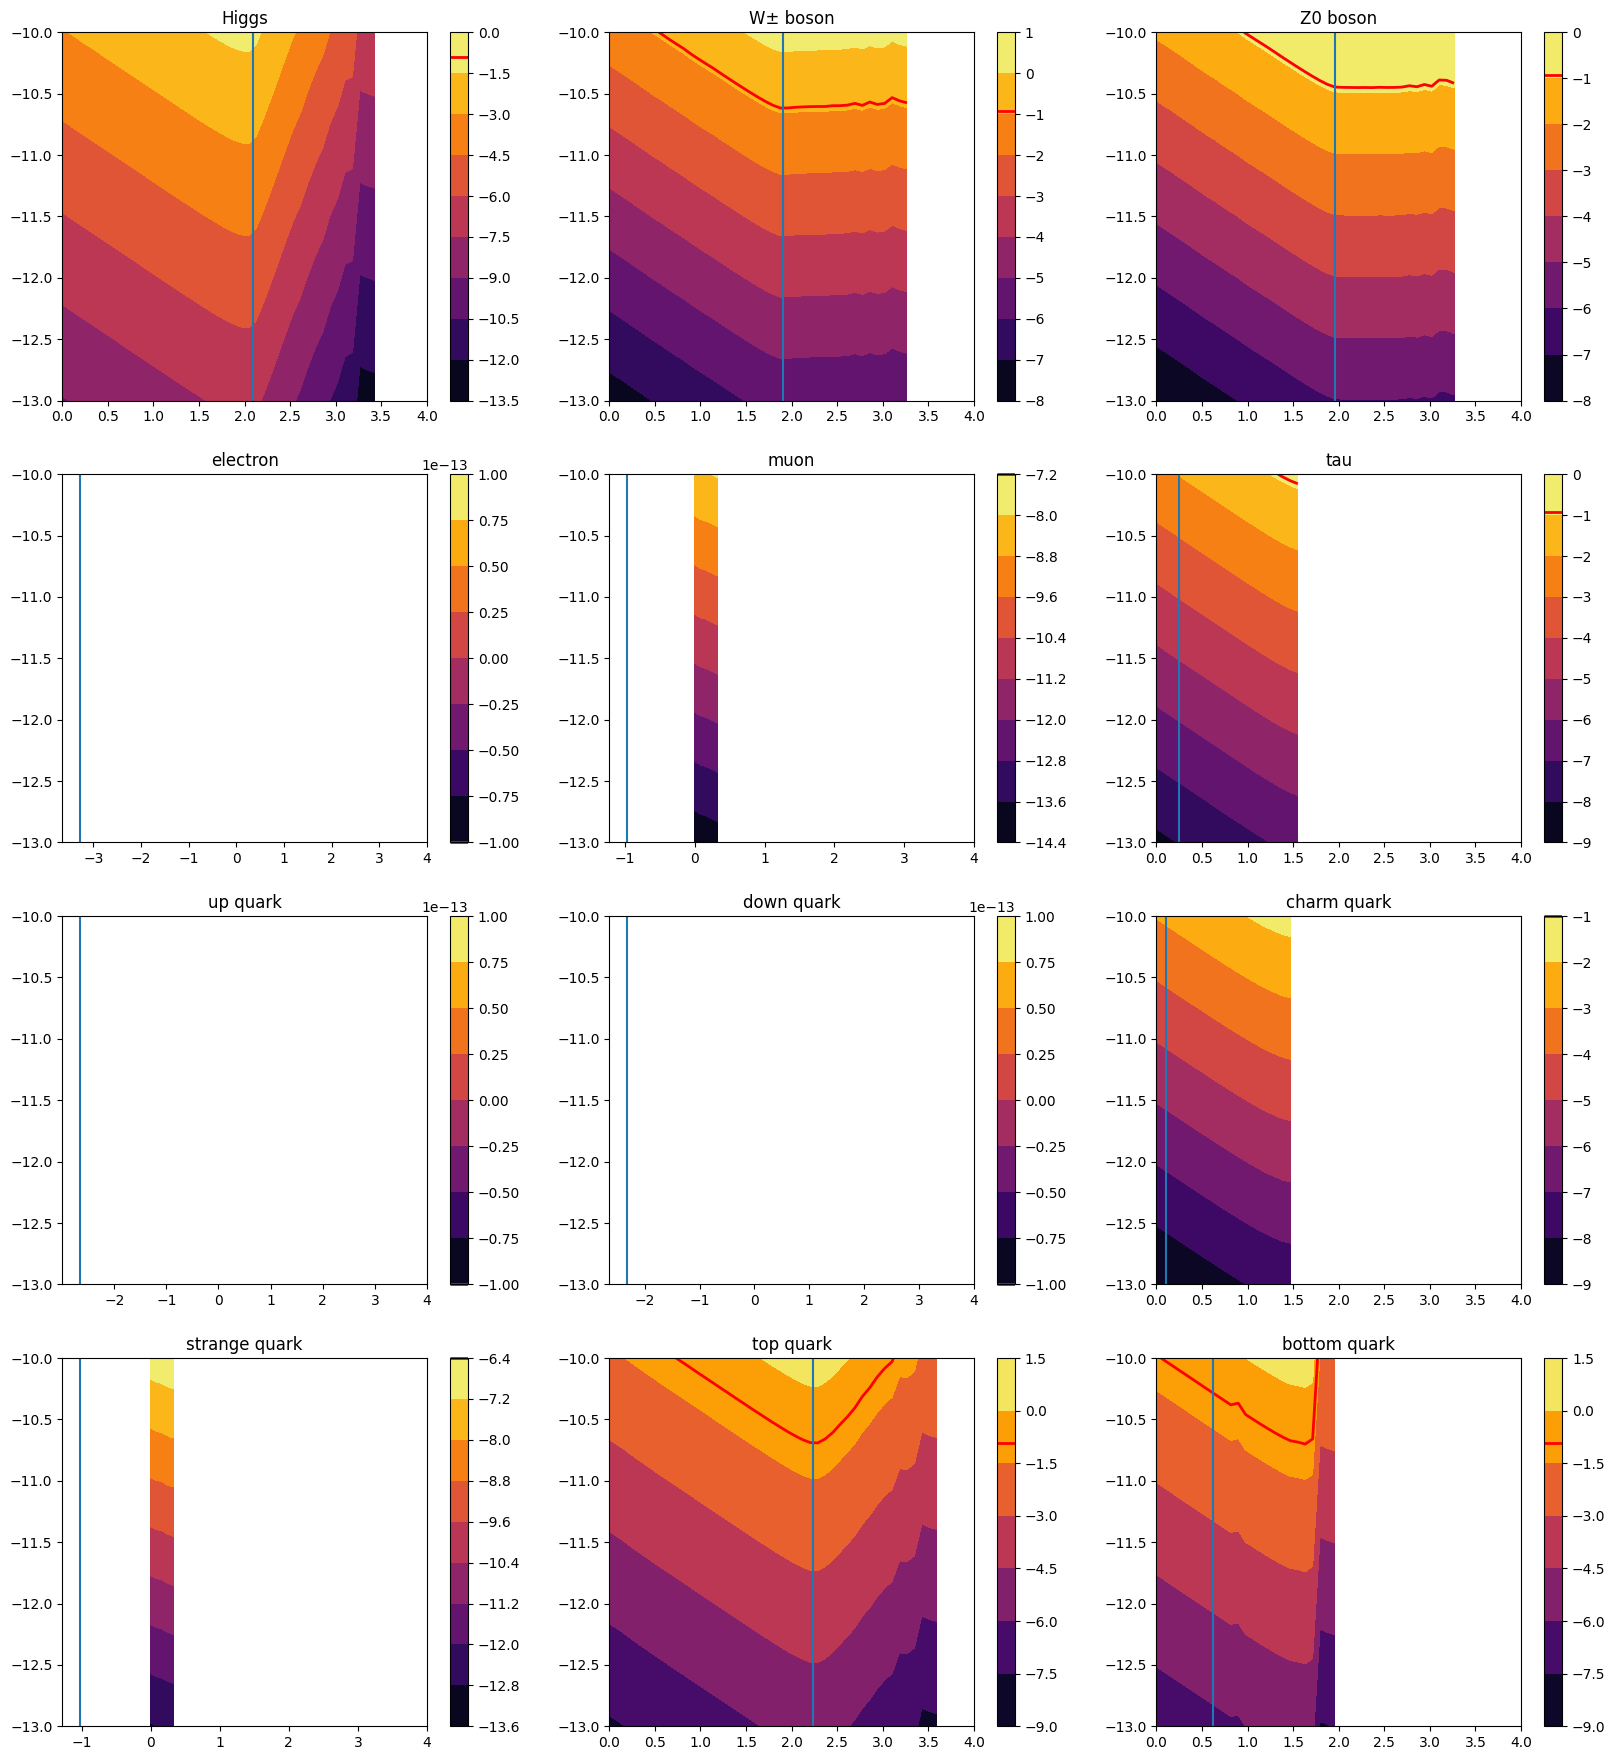

In [38]:
fig, ax = plt.subplots(4,3,figsize=(20,22))
for i,part in enumerate(SM_particles.index):
    OO = Omegah2(MM,LL,1e12,part)
    CS = ax[i//3,i%3].contourf(np.log10(MM),np.log10(LL),np.log10(OO),cmap='inferno',)
    CSl = ax[i//3,i%3].contour(CS,levels=[np.log10(0.12),],colors='red',linestyles='solid',linewidths=2)
    ax[i//3,i%3].vlines(np.log10(SM_particles.loc[part]['mass']),-13,-10)
    cbar = fig.colorbar(CS)
    cbar.add_lines(CSl)
    ax[i//3,i%3].set(title=SM_particles.loc[part]['name'])
    print(SM_particles.loc[part]['name'] + ' completed')

In [14]:
micromegas = pd.read_csv('params_micromegas.csv')

In [15]:
OO1 = Omegah2(MM,LL,1e6,'all')
# OO2 = Omegah2(MM,LL,1e2,'all')
# OO3 = Omegah2(MM,LL,1,'all')


/tmp/ipykernel_10735/1927640927.py:31: RuntimeWarning: invalid value encountered in scalar power
  B_ = ((np.tan(w)-M_S**2/M**2)*(np.tan(w)-1))**0.5
/tmp/ipykernel_10735/1927640927.py:20: RuntimeWarning: invalid value encountered in scalar power
  B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1))**0.5
/tmp/ipykernel_10735/1927640927.py:10: RuntimeWarning: invalid value encountered in scalar power
  B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1))**0.5


/tmp/ipykernel_10735/1110177607.py:2: RuntimeWarning: divide by zero encountered in log10
  CS = ax.contourf(np.log10(MM),np.log10(LL),np.log10(OO1),cmap='inferno',)
/tmp/ipykernel_10735/1110177607.py:3: RuntimeWarning: divide by zero encountered in log10
  CSl = ax.contour(np.log10(MM),np.log10(LL),np.log10(OO1),levels=[np.log10(0.12),np.log10(0.26)],colors='red',linestyles='solid',linewidths=2)


Higgs completed


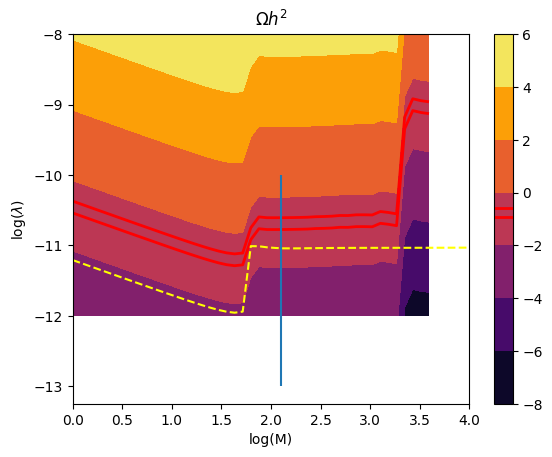

In [18]:
fig, ax = plt.subplots()
CS = ax.contourf(np.log10(MM),np.log10(LL),np.log10(OO1),cmap='inferno',)
CSl = ax.contour(np.log10(MM),np.log10(LL),np.log10(OO1),levels=[np.log10(0.12),np.log10(0.26)],colors='red',linestyles='solid',linewidths=2)
#CSl = ax.contour(np.log10(MM),np.log10(LL),np.log10(OO2),levels=[np.log10(0.12),],colors='blue',linestyles='solid',linewidths=2)
#CSl = ax.contour(np.log10(MM),np.log10(LL),np.log10(OO3),levels=[np.log10(0.12),],colors='green',linestyles='solid',linewidths=2)
ax.plot(micromegas['M'],micromegas['lambda'],color = 'yellow',linestyle = '--')
ax.vlines(np.log10(SM_particles.loc['h']['mass']),-13,-10)
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)
ax.set(title=r'$\Omega h^2$',xlabel='log(M)',ylabel=r'$\log(\lambda)$')
print(SM_particles.loc['h']['name'] + ' completed')

plt.show()

In [54]:
OO3

array([[2.24585213e-011, 2.54772762e-011, 2.72939238e-011,
        2.66919932e-011, 2.31851135e-011, 1.71016829e-011,
        1.11864235e-011, 6.90167554e-012, 3.76152686e-012,
        1.39825546e-012, 3.03901302e-013, 3.71265860e-014,
        2.60198423e-015, 6.51688002e-017, 2.75567573e-018,
        4.40423348e-021, 4.04566273e-026, 2.06584826e-026,
        4.39228686e-034, 8.35369914e-035, 4.15482388e-051,
        3.46652536e-051, 5.35491531e-053, 5.87612924e-072,
        2.09259244e-081, 1.05372959e-097, 1.24001830e-116,
        2.51707578e-141, 7.04865768e-170, 3.29413423e-208,
        8.42617821e-249, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [1.738

In [54]:
def sigma_s_plot(s,M_S,lambda_HS,initial_particle):
    if initial_particle == 'h':
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        A_ = g**-2*lambda_HS**2/(32*np.pi*s)
        B_ = ((s-4*M_S**2)/(s-4*M**2))**0.5
        C_ = (lambda_HS+3*M/(s-M**2+1j*M*Gamma_h)-4*vev**2*lambda_HS/(s-2*M**2))
        return A_*B_*np.abs(C_)**2
    
    if SM_particles.loc[initial_particle]['spin'] == 1.:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']

        A_ = g**-2*lambda_HS**2/(32*np.pi*s)
        B_ = ((s-4*M_S**2)/(s-4*M**2))**0.5
        C_ = (s**2-4*s*M**2+12*M**4)/((s-m_h**2)**2+m_h**2*Gamma_h**2)
        return A_*B_*C_

    if SM_particles.loc[initial_particle]['spin'] == 0.5:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        n = SM_particles.loc[initial_particle]['n_c']

        A_ = g**-2*lambda_HS**2*n/(16*np.pi*s)
        B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5
        C_ = 1/((s-m_h**2)**2+m_h**2*Gamma_h**2)
        return A_*B_*C_


def Gamma_hSS(lambda_HS,M_S):
    if M_S < m_h/2:
        return lambda_HS**2*vev**2/(32*np.pi*m_h)*(1-4*M_S**2/m_h**2)**0.5
    else:
        return 0

In [55]:
from ipywidgets import interact,fixed,widgets,interactive

$$
\langle\sigma v\rangle = \dfrac{1}{8m_X^4TK^2_2(m/T)}\int_{4m_X^2}^\infty\sigma(s-4m_X^2)\sqrt{s}K_1(\sqrt{s}/T)\mathrm{d}s
$$

In [71]:
def graf1(M_S,l_HS,T):
    ss = np.logspace(np.log10(M_S),20,1000)
    sigmas = sigma_s(ss,M_S,l_HS,'h')*(ss-4*M_S**2)*ss**0.5*kn(1,ss**0.5/T)
    plt.loglog(ss,sigmas,color='r')
    # plt.loglog(xss,Yeq(xss,mass,g),label=r'$Y_{eq}$',color='b')
    # plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
    # plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
    # #plt.ylim(2e-8,1e-2)
    # plt.title('Boltzmann equation for WIMPs')
    # plt.xlabel('x')
    # plt.ylabel('Y')
    plt.grid()
    # plt.legend()
    plt.show()
    
slider_M_S = widgets.FloatLogSlider(value=100, base=10, min=0, max=4,
                                  step=0.01, description='mass')
slider_l_HS = widgets.FloatLogSlider(value=1e-11, base=10, min=-13, max=-9,
                                  step=0.1, description='sigma')
slider_T = widgets.FloatLogSlider(value=1, base=10, min=-12, max=12,
                                  step=0.1, description='sigma')

interactive_plot1 = interactive(graf1, M_S=slider_M_S, l_HS=slider_l_HS, T=slider_T,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot1

interactive(children=(FloatLogSlider(value=100.0, description='mass', step=0.01), FloatLogSlider(value=1e-11, …

In [ ]:
def Boltz_eq(x,M_S,lambda_HS):
    HMS = (np.pi**2*geff(M_S/x)/90)**0.5*M_S**2/MP
    sMS = 2*np.pi**2/45*heff(M_S/x)*M_S**3
    HMS = HMS/(1+(1/3)*dlnheffdlnT(np.log(M_S/x)))
    suma = 0
    for part in SM_particles.index:
        M = SM_particles.loc[part]['mass']
        g = SM_particles.loc[part]['dof']
        integrand = lambda s: sigma_s(s,M_S,lambda_HS,part)*(s-4*M_S**2)*s**0.5*kn(1,s**0.5*M_S/x)
        res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5,limit=100)[0]
        suma += (g**2/np.pi**4)*M_S*M**5/x*res

    return x**4/(HMS*sMS)*(suma+C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))

In [73]:
def graf2(M_S,l_HS):
    Ts = np.logspace(-12,12,1000)
    xs = M_S/Ts
    dYdx = Boltz_eq(xs,M_S,l_HS)
    plt.loglog(xs,dYdx,color='r')
    # plt.loglog(xss,Yeq(xss,mass,g),label=r'$Y_{eq}$',color='b')
    # plt.hlines(Yfin,xini,xfin,color='k',linestyle=':')
    # plt.axhspan(0.9*Yfin,1.1*Yfin,0,1,color='yellow',alpha=0.5)
    # #plt.ylim(2e-8,1e-2)
    # plt.title('Boltzmann equation for WIMPs')
    # plt.xlabel('x')
    # plt.ylabel('Y')
    plt.grid()
    # plt.legend()
    plt.show()
    
slider_M_S = widgets.FloatLogSlider(value=100, base=10, min=0, max=4,
                                  step=0.01, description='mass')
slider_l_HS = widgets.FloatLogSlider(value=1e-11, base=10, min=-13, max=-9,
                                  step=0.1, description='sigma')

interactive_plot2 = interactive(graf2, M_S=slider_M_S, l_HS=slider_l_HS, T=slider_T,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot2

interactive(children=(FloatLogSlider(value=100.0, description='mass', step=0.01), FloatLogSlider(value=1e-11, …

In [57]:
1e-51 == 0

False

/tmp/ipykernel_26065/3735654403.py:4: RuntimeWarning: divide by zero encountered in log10
  CS = ax.contourf(np.log10(MM),np.log10(LL),np.log10(OO_),cmap='inferno',)
/tmp/ipykernel_26065/3735654403.py:6: RuntimeWarning: divide by zero encountered in log10
  CSl2 = ax.contour(np.log10(MM),np.log10(LL),np.log10(OO),levels=[np.log10(0.12),],colors='blue',linestyles='solid',linewidths=2)


[Text(0.5, 1.0, 'h decay')]

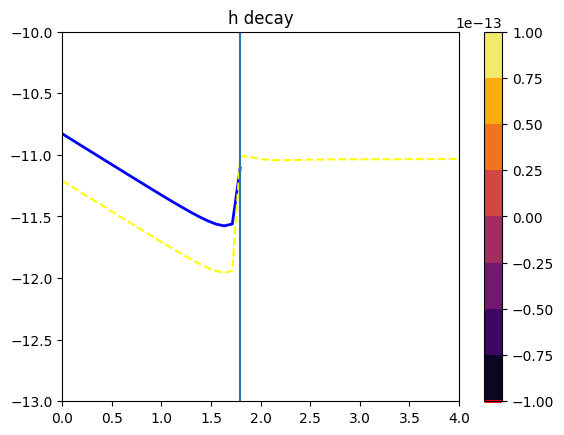

In [36]:
fig, ax = plt.subplots()
OO = Omegah2(MM,LL,1e12,'decay')
OO_ = Omegah2_v2(MM,LL,1e12,'decay')
CS = ax.contourf(np.log10(MM),np.log10(LL),np.log10(OO_),cmap='inferno',)
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='red',linestyles='solid',linewidths=2)
CSl2 = ax.contour(np.log10(MM),np.log10(LL),np.log10(OO),levels=[np.log10(0.12),],colors='blue',linestyles='solid',linewidths=2)
ax.plot(micromegas['M'],micromegas['lambda'],color = 'yellow',linestyle = '--')
ax.vlines(np.log10(m_h/2),-13,-10)
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)
ax.set(title='h decay')

----------------

In [37]:
def Omegah2_gaussian(M_S,lambda_HS,TR,channel):
    def Boltz_eq(x):
        # HMS = (np.pi**2*gstar/90)**0.5*M_S**2/MP
        # sMS = 2*np.pi**2/45*gstars0*M_S**3
        HMS = (np.pi**2*geff(M_S/x)/90)**0.5*M_S**2/MP
        sMS = 2*np.pi**2/45*heff(M_S/x)*M_S**3
        HMS = HMS/(1+(1/3)*dlnheffdlnT(np.log(M_S/x)))
        if channel == 'all':
            suma = 0
            for part in SM_particles.index:
                M = SM_particles.loc[part]['mass']
                g = SM_particles.loc[part]['dof']
                integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma(w,M_S,lambda_HS,part)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
                res = fixed_quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5)[0]
                suma += (g**2/np.pi**4)*M_S*M**5/x*res
        
            return x**4/(HMS*sMS)*(suma+C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
        elif channel == 'decay':
            return x**4/(HMS*sMS)*(C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
        else:
            M = SM_particles.loc[channel]['mass']
            g = SM_particles.loc[channel]['dof']
            n = SM_particles.loc[channel]['n_c']
            cx = SM_particles.loc[channel]['antiparticle']
            integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma(w,M_S,lambda_HS,channel)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
            res = fixed_quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5)[0]
            term = ((g*n)**2*cx/np.pi**4)*M_S*M**5/x*res
            return x**4/(HMS*sMS)*term
    x0 = M_S/TR
    Y = fixed_quad(Boltz_eq,x0,M_S/T0)[0]
    #return Y
    return s0mo*M_S*Y/rhoc0mo

Omegah2_gaussian = np.vectorize(Omegah2_gaussian)

/tmp/ipykernel_26065/3434090434.py:4: RuntimeWarning: divide by zero encountered in log10
  CS = ax.contourf(np.log10(MM),np.log10(LL),np.log10(OO),cmap='inferno',)


[Text(0.5, 1.0, 'h decay')]

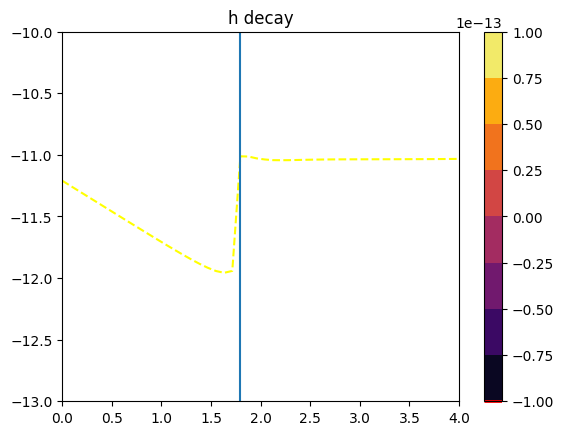

In [38]:
fig, ax = plt.subplots()
OO = Omegah2_gaussian(MM,LL,1e12,'decay')
#OO_ = Omegah2_v2(MM,LL,1e12,'decay')
CS = ax.contourf(np.log10(MM),np.log10(LL),np.log10(OO),cmap='inferno',)
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='red',linestyles='solid',linewidths=2)
#CSl2 = ax.contour(np.log10(MM),np.log10(LL),np.log10(OO),levels=[np.log10(0.12),],colors='blue',linestyles='solid',linewidths=2)
ax.plot(micromegas['M'],micromegas['lambda'],color = 'yellow',linestyle = '--')
ax.vlines(np.log10(m_h/2),-13,-10)
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)
ax.set(title='h decay')

In [39]:
rdof

,Temp,g_s,g_rho,lnTemp,lnheff
0,5.000000e+05,104.51300,104.51600,13.122363,4.649311
1,4.530790e+05,104.51000,104.51300,13.023822,4.649283
2,4.105620e+05,104.50700,104.51000,12.925282,4.649254
3,3.720340e+05,104.50400,104.50700,12.826741,4.649225
4,3.371220e+05,104.50100,104.50400,12.728200,4.649197
...,...,...,...,...,...
246,1.483140e-05,3.91752,3.37064,-11.118764,1.365459
247,1.343960e-05,3.91750,3.37062,-11.217305,1.365454
248,1.217840e-05,3.91751,3.37063,-11.315847,1.365456
249,1.103560e-05,3.91757,3.37070,-11.414384,1.365472


In [40]:
a_int = lambda T: (1+1/3*dlnheffdlnT(T))/np.log(10)

In [41]:
aTR = quad(a_int,np.log10(1e12),np.log10(T0),limit=1000)
aTR

/tmp/ipykernel_26065/2499840020.py:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  aTR = quad(a_int,np.log10(1e12),np.log10(T0),limit=1000)


(-11.17168084188426, 0.0005530845092385405)

----------------

In [42]:
def Omegah2_v3(M_S,lambda_HS,TR,channel,plot_BE=True):
    def Boltz_eq(T):
        H = (np.pi**2*geff(T)/90)**0.5*T**2/MP
        s = 2*np.pi**2/45*heff(T)*T**3
        Hbar = H#/(1+(1/3)*dlnheffdlnT(np.log(T)))

        if channel == 'all':
            suma = 0
            for part in SM_particles.index:
                M = SM_particles.loc[part]['mass']
                g = SM_particles.loc[part]['dof']
                integrand = lambda w: (g**2/np.pi**4)*M**5*((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma(w,M_S,lambda_HS,part)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
                res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5)[0]
                suma += res
        
            return 1/(Hbar*s)*(suma+C*m_h**2/(2*np.pi**2)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/T))
        elif channel == 'decay':
            return 1/(Hbar*s)*(C*m_h**2/(2*np.pi**2)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/T))
        else:
            M = SM_particles.loc[channel]['mass']
            g = SM_particles.loc[channel]['dof']
            n = SM_particles.loc[channel]['n_c']
            cx = SM_particles.loc[channel]['antiparticle']
            integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma(w,M_S,lambda_HS,channel)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
            res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5)[0]
            term = ((g*n)**2*cx/np.pi**4)*M**5*res
            return 1/(Hbar*s)*term
    integ = lambda T: M_S*s0mo*Boltz_eq(T)/rhoc0mo
    TS = np.logspace(np.log10(T0),np.log10(TR),100)
    plt.semilogx(TS,integ(TS))
    omega = quad(integ,0,np.inf)[0]
    return omega
    #return Y

Omegah2_v3 = np.vectorize(Omegah2_v3)

In [43]:
M_S = 1
f1 = lambda T: kn(1,m_h/T)/T**5
f2 = lambda x: -kn(1,m_h/M_S*x)*x**3/M_S**4

TR = 1e12

quad(f1,np.inf,TR)[0],quad(f2,0,np.inf)

(-1.1151867080843837e-47, (-1.9178897739412722e-08, 2.997495636906274e-09))

/tmp/ipykernel_26065/4245832569.py:31: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  omega = quad(integ,0,np.inf)[0]
/tmp/ipykernel_26065/4245832569.py:31: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  omega = quad(integ,0,np.inf)[0]
/tmp/ipykernel_26065/2216715338.py:3: RuntimeWarning: divide by zero encountered in log10
  CS = ax.contourf(np.log10(MM),np.log10(LL),np.log10(OO),cmap='inferno',)


[Text(0.5, 1.0, 'h decay')]

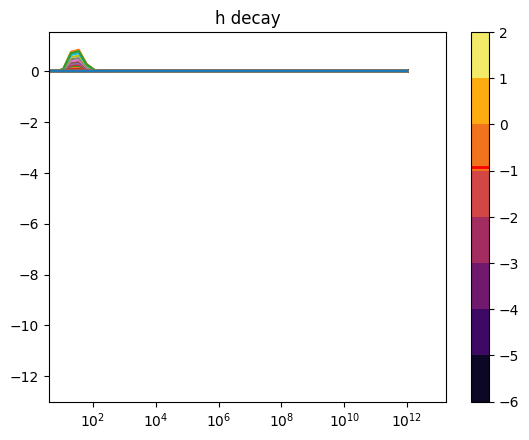

In [44]:
fig, ax = plt.subplots()
OO = Omegah2_v3(MM,LL,1e12,'decay')
CS = ax.contourf(np.log10(MM),np.log10(LL),np.log10(OO),cmap='inferno',)
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='red',linestyles='solid',linewidths=2)
ax.plot(micromegas['M'],micromegas['lambda'],color = 'yellow',linestyle = '--')
ax.vlines(np.log10(m_h/2),-13,-10)
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)
ax.set(title='h decay')

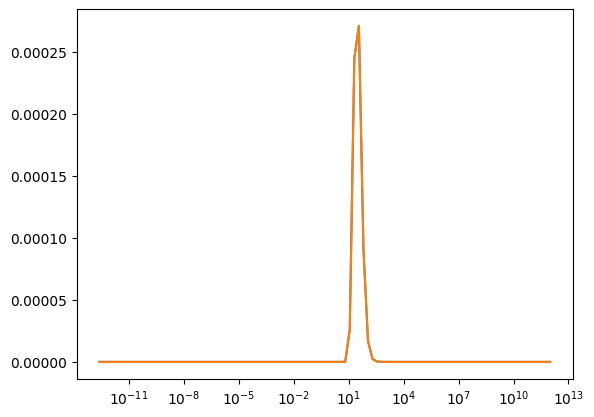

In [45]:
OO = Omegah2_v3(1,1e-11,1e12,'decay')

# Otros

In [46]:
def sigma_s(s,M_S,lambda_HS,initial_particle):
    if initial_particle == 'h':
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        A_ = g**-2*lambda_HS**2/(32*np.pi*s)
        B_ = ((s-4*M_S**2)/(s-4*M**2)+0j)**0.5
        C_ = (lambda_HS+3*M/(s-M**2+1j*M*Gamma_h)-4*vev**2*lambda_HS/(s-2*M**2))
        return (A_*B_*np.abs(C_)**2).real
    if SM_particles.loc[initial_particle]['spin'] == 1.:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        A_ = g**-2*lambda_HS**2/(32*np.pi*s)
        B_ = ((s-4*M_S**2)/(s-4*M**2)+0j)**0.5
        C_ = (s**2-4*s*M**2+12*M**4)/((s-m_h**2)**2+m_h**2*Gamma_h**2)
        return (A_*B_*C_).real
    if SM_particles.loc[initial_particle]['spin'] == 0.5:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        n = SM_particles.loc[initial_particle]['n_c']
        A_ = g**-2*lambda_HS**2*n/(16*np.pi*s)
        B_ = ((s-4*M_S**2)*(s-4*M**2)+0j)**0.5
        C_ = 1/((s-m_h**2)**2+m_h**2*Gamma_h**2)
        return (A_*B_*C_).real
    
def Gamma_hSS(lambda_HS,M_S):
    return (lambda_HS**2*vev**2/(32*np.pi*m_h)*(1-4*M_S**2/m_h**2+0j)**0.5).real


In [47]:
def Omegah2(M_S,lambda_HS,channel):
    def Boltz_eq(x):
        HMS = (np.pi**2*gstar/90)**0.5*M_S**2/MP
        sMS = 2*np.pi**2/45*gstar*M_S**3
        if channel == 'all':
            suma = 0
            for part in SM_particles.index:
                M = SM_particles.loc[part]['mass']
                g = SM_particles.loc[part]['dof']
                n = SM_particles.loc[part]['n_c']
                cx = SM_particles.loc[part]['antiparticle']
                integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma_s(4*M**2*np.tan(w),M_S,lambda_HS,part)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
                res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5)[0]
                suma += ((g*n)**2*cx/np.pi**4)*M_S*M**5/x*res
            return x**4/(HMS*sMS)*(suma+C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
        else:
            M = SM_particles.loc[channel]['mass']
            g = SM_particles.loc[channel]['dof']
            n = SM_particles.loc[channel]['n_c']
            cx = SM_particles.loc[channel]['antiparticle']
            integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma_s(4*M**2*np.tan(w),M_S,lambda_HS,part)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
            res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5)[0]
            term = ((g*n)**2*cx/np.pi**4)*M_S*M**5/x*res
            return x**4/(HMS*sMS)*(term+C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
    Y = quad(Boltz_eq,M_S/1e12,np.inf,limit=100)[0]
    return s0*M_S*Y/(3*MP**2*(1.45e-42)**2)*0.68**2
    
Omegah2 = np.vectorize(Omegah2)

In [48]:
OO = Omegah2(MM,LL,'all')

KeyboardInterrupt: 

In [ ]:
def Omegah2_v4(M_S,lambda_HS,channel):
    def Boltz_eq(x):
        HMS = (np.pi**2*gstar/90)**0.5*M_S**2/MP
        sMS = 2*np.pi**2/45*gstar*M_S**3
        if channel == 'all':
            suma = 0
            for part in SM_particles.index:
                M = SM_particles.loc[part]['mass']
                g = SM_particles.loc[part]['dof']
                n = SM_particles.loc[part]['n_c']
                cx = SM_particles.loc[part]['antiparticle']
                integrand = lambda w: ((M_S**2*np.tan(w)-M**2)*np.tan(w)**0.5/(np.cos(w)**2)*sigma_s(4*M_S**2*np.tan(w),M_S,lambda_HS,part)*kn(1,2*np.tan(w)**0.5*x)).real
                res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5)[0]
                suma += ((g*n)**2*cx/np.pi**4)*M_S**3/x*res
            
        return x**4/(HMS*sMS)*(suma+C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
    Y = quad(Boltz_eq,M_S/1e15,np.inf,limit=100)[0]
    return s0*M_S*Y/(3*MP**2*(1.45e-42)**2)*0.68**2
    
Omegah2_v4 = np.vectorize(Omegah2_v4)

In [ ]:
Omegah2_v4(1000,10**-11,'all')

array(7.39598288e-06)

In [ ]:
OO = Omegah2_v4(MM,LL,'all')

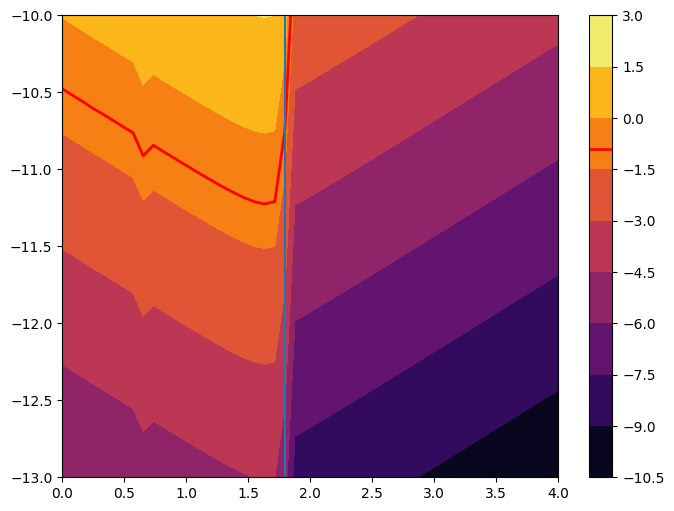

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(np.log10(MM),np.log10(LL),np.log10(OO),cmap='inferno',)
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='red',linestyles='solid',linewidths=2)
ax.vlines(np.log10(m_h/2),-13,-10)
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)

In [ ]:
def Omegah2_v2(M_S,lambda_HS,TR=1e12):
    def integrand1(T):
        HT = (np.pi**2*gstar/90)**0.5*T**2/MP
        sT = 2*np.pi**2/45*gstar*T**3
        suma = 0
        for part in SM_particles.index:
            M = SM_particles.loc[part]['mass']
            g = SM_particles.loc[part]['dof']
            n = SM_particles.loc[part]['n_c']
            cx = SM_particles.loc[part]['antiparticle']
            integrand2 = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma_s(4*M**2*np.tan(w),M_S,lambda_HS,part)*kn(1,2*M/T*np.tan(w)**0.5)).real
            suma += M**5*(g*n)**2*cx*quad(integrand2,np.pi/4+1e-5,np.pi/2-1e-5)[0]
        term1 = suma/(np.pi**4)
        term2 = SM_particles.loc['h']['dof']*SM_particles.loc['h']['mass']**2/(2*np.pi**2)*C*Gamma_hSS(lambda_HS,M_S)*kn(1,SM_particles.loc['h']['mass']/T)
        return 1/(HT*sT)*(term1+term2)
    Y = quad(integrand1,M_S/T0,np.inf)[0]
    return s0*M_S*Y/(3*MP**2*(1.45e-42)**2)*0.68**2

Omegah2_v2 = np.vectorize(Omegah2_v2)
            

In [ ]:
Omegah2_v2(1,10**-10.5)

array(8.5487736e-42)

In [ ]:
s0/(3*MP**2*(1.45e-42)**2)*0.68**2

282650822.8687433

In [ ]:
def Boltz_eq(x,Y,M_S,lambda_HS):
    HMS = (np.pi**2*gstar/90)**0.5*M_S**2/MP
    sMS = 2*np.pi**2/45*gstar*M_S**3
    suma = 0
    for part in SM_particles.index:
        M = SM_particles.loc[part]['mass']
        g = SM_particles.loc[part]['dof']
        n = SM_particles.loc[part]['n_c']
        cx = SM_particles.loc[part]['antiparticle']
        integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma_s(4*M**2*np.tan(w),M_S,lambda_HS,part)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
        res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5)[0]
        suma += ((g*n)**2*cx/np.pi**4)*M_S*M**5/x*res

    dYdx = x**4/(HMS*sMS)*(suma+C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
    return dYdx

Boltz_eq = np.vectorize(Boltz_eq)

In [ ]:
Boltz_eq(1,1,1,1)

array(399924.37869518)

In [ ]:
def Omegah2_v3(M_S,lambda_HS,TR):
    xini = M_S/TR
    xfin = M_S/T0
    Yini = 0
    sol = solve_ivp(Boltz_eq, [xini,xfin], [Yini,], method='BDF', rtol=1e-8, atol=1e-10, args=(M_S,lambda_HS))
    xs = sol.t
    Os = s0*M_S*sol.y[0]/(3*MP**2*(1.45e-42)**2)*0.68**2
    plt.loglog(xs,Os,color='r')
    print(Os[-1])


1.2642550157235257e-12


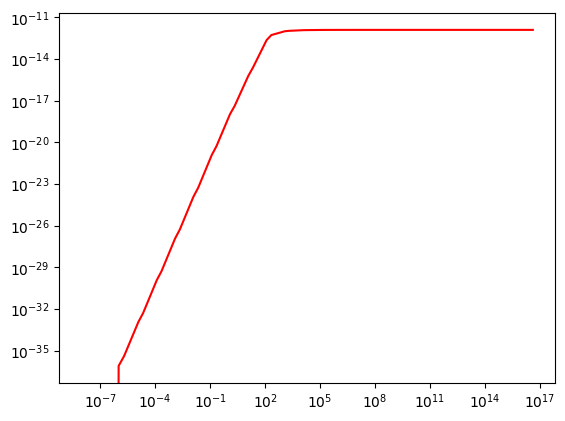

In [ ]:
Omegah2_v3(1e4,1e-11,1e12)

In [ ]:
def Omegah2_v5(M_S,lambda_HS,TR):
    def Boltz_eq(x):
        HMS = (np.pi**2*gstar/90)**0.5*M_S**2/MP
        sMS = 2*np.pi**2/45*gstar*M_S**3
        suma = 0
        for part in SM_particles.index:
            M = SM_particles.loc[part]['mass']
            g = SM_particles.loc[part]['dof']
            integrand = lambda s: ((s-4*M**2)*sigma_s(s,M_S,lambda_HS,initial_particle=part)*s**0.5*kn(1,s**0.5*x/M_S)).real
            res = quad(integrand,4*M**2,np.inf)[0]
            suma += (g**2/(32*np.pi**4))*M_S/x*res
    
        return x**4/(HMS*sMS)*(suma+C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
    x0 = M_S/TR
    Y = quad(Boltz_eq,x0,np.inf)[0]
    return Y

Omegah2_v5 = np.vectorize(Omegah2_v5)

KeyboardInterrupt: 

In [ ]:
Omegah2_v5(1000,1e-11,1e12)/1000

3.624094503409201e-29

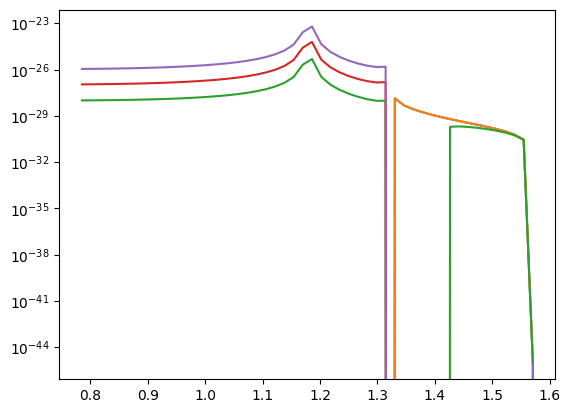

In [ ]:
ws = np.linspace(np.pi/4,np.pi/2)
plt.semilogy(ws,sigma_s(M_W**2*np.tan(ws),1,1e-11,'W'))
plt.semilogy(ws,sigma_s(M_W**2*np.tan(ws),10,1e-11,'W'))
plt.semilogy(ws,sigma_s(M_W**2*np.tan(ws),100,1e-11,'W'))
plt.semilogy(ws,sigma_s(M_W**2*np.tan(ws),1000,1e-11,'W'))
plt.semilogy(ws,sigma_s(M_W**2*np.tan(ws),10000,1e-11,'W'))

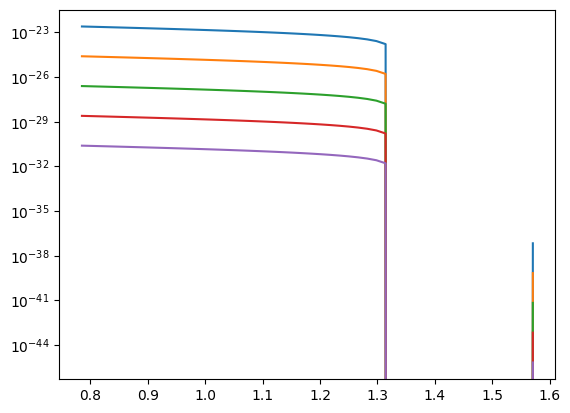

In [ ]:
ws = np.linspace(np.pi/4,np.pi/2)
plt.semilogy(ws,sigma_s(np.tan(ws),1,1e-9,'W'))
plt.semilogy(ws,sigma_s(np.tan(ws),1,1e-10,'W'))
plt.semilogy(ws,sigma_s(np.tan(ws),1,1e-11,'W'))
plt.semilogy(ws,sigma_s(np.tan(ws),1,1e-12,'W'))
plt.semilogy(ws,sigma_s(np.tan(ws),1,1e-13,'W'))

## Graficar $$sigma v$$ 

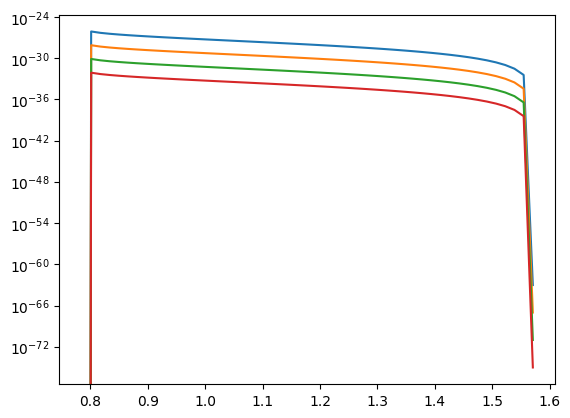

In [ ]:
ws = np.linspace(np.pi/4,np.pi/2)
plt.semilogy(ws,sigma(ws,1,1e-10,'h'))
plt.semilogy(ws,sigma(ws,1,1e-11,'h'))
plt.semilogy(ws,sigma(ws,1,1e-12,'h'))
plt.semilogy(ws,sigma(ws,1,1e-13,'h'))

# Cálculo de I

$$I(m_S) = \int_{x_R}^{x_0}x^3K_1\left(\dfrac{m_h}{m_S}x\right)\mathrm{d}x$$

In [ ]:
def integral_decay(m_S):
    T_R = 1e12
    x_R = m_S/1e12
    func = lambda x: x**3*kn(1,m_h/m_S*x)
    I = quad(func,x_R,np.inf)[0]
    return I

integral_decay = np.vectorize(integral_decay)

In [ ]:
rhoc0

3.6777714121794717e-19

/tmp/ipykernel_11290/3205575627.py:4: RuntimeWarning: invalid value encountered in sqrt
  F = ((0.12/alphap*MSs**3/Is*1/(1-4*MSs**2/m_h**2)**0.5)**0.5).real


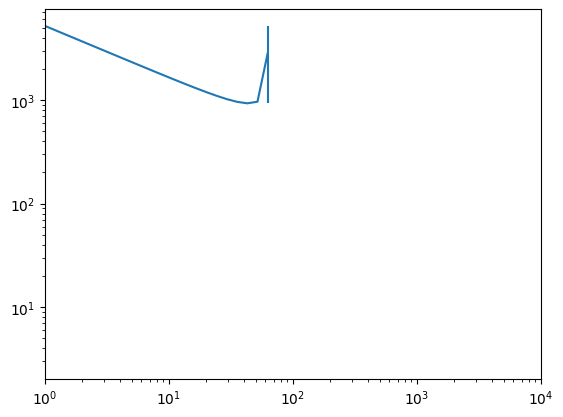

In [ ]:
MSs = np.logspace(0,4)
Is = integral_decay(MSs)
alphap = s0/rhoc0*C*m_h/(128*np.pi**5*(np.pi**2*gstar/(90*MP**2))**0.5*(1/(45*gstar)))
F = ((0.12/alphap*MSs**3/Is*1/(1-4*MSs**2/m_h**2)**0.5)**0.5).real
plt.loglog(MSs,F)
plt.xlim(1,1e4)
#plt.ylim(1e3,1e4)
plt.vlines(m_h/2,np.nanmin(F),np.nanmax(F))

In [ ]:
alphap

0.23275994024011729